# DL톤 해파리 분류기
아이펠 코어 12기 팀: 해파리지앵  
@author: Hyeseung Lee  
Created: 2025-04-01

## Introduction

해파리 분류기 노트북 코드 요약 설명
이 노트북 코드는 딥러닝을 사용하여 해파리 이미지를 분류하는 모델을 구축하고 훈련하는 과정을 담고 있습니다. 주요 기능과 단계는 다음과 같습니다.

1. 데이터 준비 및 전처리:

Google Drive에 저장된 해파리 이미지 데이터셋을 불러옵니다. 데이터셋은 훈련, 검증, 테스트셋으로 나뉘어져 있습니다.
load_dataset_from_directory 함수를 사용하여 이미지를 로드하고 크기를 조정합니다.
count_images_per_class 함수를 사용하여 각 클래스별 이미지 개수를 확인하고 데이터 분포를 파악합니다.
get_class_labels 함수를 사용하여 디렉토리 구조를 기반으로 클래스 레이블을 자동으로 추출합니다.
2. 데이터 증강:

AugmentationManager 클래스를 사용하여 훈련 이미지에 대한 데이터 증강 파이프라인을 생성합니다.
회전, 이동, 확대/축소, 수평 뒤집기 등 다양한 증강 기법을 적용하여 모델의 일반화 성능을 향상시킵니다.
apply_augmentation 함수를 사용하여 증강된 이미지를 생성하고 시각화하여 증강 결과를 확인합니다.
gaussian_blur, salt_and_pepper_noise, gaussian_noise 함수를 통해 추가적인 노이즈 증강 기법을 적용할 수 있습니다.
3. 모델 구축 및 훈련:

JellyfishClassifier 클래스를 사용하여 해파리 분류 모델을 정의합니다.
EfficientNet, MobileNet, ResNet 등 다양한 사전 훈련된 모델을 기반으로 모델을 구축할 수 있습니다.
fit 메서드를 사용하여 모델을 훈련합니다. 훈련 과정에서 검증 데이터를 사용하여 모델 성능을 평가하고 조기 종료 및 체크포인트 기능을 활용하여 최적의 모델을 저장합니다.
훈련 중에는 TqdmCallback을 사용하여 진행 상황을 시각적으로 표시합니다.
ReduceLROnPlateau 콜백을 사용하여 검증 손실이 정체될 경우 학습률을 조정합니다.
4. 모델 평가 및 시각화:

evaluate 메서드를 사용하여 테스트 데이터셋에 대한 모델 성능을 평가합니다. 정확도, F1 점수, 엔트로피 등 다양한 지표를 사용하여 모델 성능을 측정합니다.
Test Time Augmentation (TTA) 기법을 적용하여 모델 예측의 정확도를 높일 수 있습니다.
k_fold_cross_validation 메서드를 사용하여 K-fold 교차 검증을 수행하고 모델의 일반화 성능을 평가합니다.
plot_confusion_matrix 함수를 사용하여 혼동 행렬을 시각화하고 모델의 예측 오류를 분석합니다.
plot_training_history 함수를 사용하여 훈련 과정에서의 손실 및 정확도 변화를 시각화합니다.
5. 모델 저장 및 로드:

save_model 메서드를 사용하여 훈련된 모델을 파일로 저장합니다.
load_model 메서드를 사용하여 저장된 모델을 불러와서 사용할 수 있습니다.
6. 예측:

predict 메서드를 사용하여 새로운 이미지에 대한 예측을 수행합니다.
TTA 기법을 적용하여 예측 정확도를 높일 수 있습니다.
요약:

이 노트북 코드는 데이터 준비, 증강, 모델 구축, 훈련, 평가, 시각화, 저장, 로드, 예측 등 딥러닝 모델 개발의 전 과정을 포함하고 있습니다. 다양한 기능과 옵션을 제공하여 사용자가 해파리 이미지 분류 모델을 효과적으로 구축하고 실험할 수 있도록 지원합니다.



---



### 라이브러리 임포트

In [ ]:
!pip install tqdm

In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python scikit-image

In [ ]:
!pip install scikit-image --upgrade

In [ ]:
!pip install albumentations

In [ ]:
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm  # Import tqdm.auto
import pandas as pd
import numpy as np
import logging
import os
import shutil
from scipy.stats import mode
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import warnings
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
import math
import random
import glob
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import cv2
import albumentations as A  # Import Albumentations
from albumentations.core.composition import OneOf

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### 함수 모듈화

In [ ]:
def load_dataset_from_directory(directory, img_size=(224, 224), batch_size=32, flatten=False):
    """폴더에서 RGB 이미지 데이터셋을 로드하는 함수 (최신 TensorFlow 방식)"""
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        seed=42,
        labels='inferred',
        label_mode='int'
    )

    # 클래스 이름 가져오기
    class_names = dataset.class_names
    class_dict = {class_name: i for i, class_name in enumerate(class_names)}

    # 데이터셋 전처리 (정규화)
    def preprocess(images, labels):
        images = tf.cast(images, tf.float32) / 255.0
        return images, labels

    dataset = dataset.map(preprocess)

    # 전체 데이터 메모리에 로드
    X_list = []
    y_list = []

    for images, labels in dataset:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    # 필요한 경우 평탄화(flatten)
    if flatten:
        X = X.reshape(X.shape[0], -1)  # (n_samples, height*width*channels)

    # 그레이스케일 특화 코드
    # 기존: elif color_mode == 'grayscale': X = X[..., 0]

    return X, y, class_dict

def get_class_labels(data_path):
  """
  디렉토리 구조를 기반으로 클래스 레이블 추론

  Args:
    data_path: 클래스 별 하위폴더를 포함하는 데이터셋의 상위 디렉토리

  Returns:
    클래스 레이블을 딕셔너리로 반환
  """
  class_labels = {}
  for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
      class_labels[folder_name] = folder_name  # Assuming directory name is the class label
  return class_labels

# Define your augmentation function
def augment(image, label,
            crop_ratio=1.0,
            saturation = (0.8, 1.2),
            brightness_max_delta=0.1,
            random_contrast=(0.9,1.1),
            random_hue = 0.1,
            random_flip_left_right = True,
            random_flip_up_down = True,
            random_rotation = 180, #TODO: THIS IS NOT WORKING AS IT IS NOT RANDOM BUT FIXED 90 DEGREES
            gaussian_noise_mean=0.0,
            gaussian_noise_stddev=0.05
            ):
    img_shape = np.array(list(image.shape))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.random_brightness(image, max_delta=brightness_max_delta)
    image = tf.image.random_contrast(image, random_contrast[0],random_contrast[1])
    image = tf.image.random_saturation(image, saturation[0], saturation[1])
    image = tf.image.random_hue(image, random_hue)
    image = tf.image.random_crop(image, size=np.hstack([img_shape[:2]*crop_ratio, [img_shape[-1]]]))  # optional crop
    image = add_gaussian_noise(image, mean=gaussian_noise_mean, stddev=gaussian_noise_stddev)
    image = tf.image.resize(image, img_shape[:2])  # restore size

    return image, label

def add_gaussian_noise(image, mean=0.0, stddev=0.05):
    noise = tf.random.normal(tf.shape(image), mean=mean, stddev=stddev)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image

class TrainingHistory(tf.keras.callbacks.Callback):
    def __init__(self, history):
        super(TrainingHistory, self).__init__()
        self.history = history  # Dictionary to store metrics

    def on_epoch_end(self, epoch, logs=None):
        # Log training and validation metrics for each epoch
        for metric, value in logs.items():
            self.history.setdefault(metric, []).append(value)

class JellyfishClassifier:
    def __init__(self, num_classes, model_type='efficientnet', input_shape=(224, 224, 3),
                 pretrained=True, metrics=None, learning_rate=0.0001):
        '''
        해파리 컬러 이미지를 분류하는 TensorFlow 기반 분류기

        Args:
            num_classes (int): 출력 클래스 개수
            model_type (str): 모델 타입 ('efficientnet', 'mobilenet', 'resnet')
            input_shape (tuple): 입력 이미지 형태 (높이, 너비, 채널)
            pretrained (bool): 사전 학습된 가중치 사용 여부
            metrics (list): 모델 평가 시 사용할 지표 리스트
            learning_rate (float): 학습률
        '''
        # 매개변수 검증 및 저장
        if not isinstance(num_classes, int) or num_classes <= 0:
            raise ValueError(f"num_classes must be positive, got {num_classes}")

        self.num_classes = num_classes
        self.input_shape = input_shape
        self.pretrained = pretrained
        self.model_type = model_type
        self.learning_rate = learning_rate

        # 메트릭 설정
        self.metrics = metrics if metrics is not None else ['accuracy']
        self._validate_metrics()

        # 모델 구축
        self.model = self._build_model()

        # 학습 이력 저장소
        self.history = {}
        self.validation_metrics = {}
        self.kfold_results = {}

    def _validate_metrics(self):
        '''메트릭 유효성 검사'''
        valid_metrics = ['accuracy', 'f1_score', 'entropy']
        for metric in self.metrics:
            if metric not in valid_metrics:
                raise ValueError(f"Unsupported metric: {metric}. Supported: {valid_metrics}")


    def _build_model(self):
        '''모델 구축'''
        # 모델 타입에 따른 기본 모델 생성
        weights = 'imagenet' if self.pretrained else None

        # ----- Device Selection -----
        if tf.test.is_gpu_available():
            device = '/GPU:0'  # Use the first available GPU
        else:
            device = '/CPU:0'

        with tf.device(device): # Use the selected device

            if self.model_type == 'efficientnet':
                base_model = applications.EfficientNetB0(weights=weights, include_top=False,
                                                        input_shape=self.input_shape)

                base_model.trainable = self.pretrained == False # self.pretrained 가 False 이면 trainable 은 True
                x = base_model.output # Assign x here for efficientnet

            elif self.model_type == 'VGG16':
                base_model = applications.VGG16(
                    weights=weights,
                    include_top=False,
                    input_shape=self.input_shape
                )
                base_model.trainable = self.pretrained == False
                # Add normalization layer after base model
                x = base_model.output

            elif self.model_type == 'mobilenet':
                base_model = applications.MobileNetV2(weights=weights, include_top=False,
                                                    input_shape=self.input_shape)
                # Add normalization layer after base model
                x = base_model.output


            elif self.model_type == 'resnet':
                base_model = applications.ResNet50(weights=weights, include_top=False,
                                                input_shape=self.input_shape)
                # Add normalization layer after base model
                x = base_model.output

            else:
                raise ValueError(f"Unsupported model type: {self.model_type}")

            # 분류 헤드 추가 (decision head)
            x = layers.Dropout(0.2)(x)
            x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling: 특징 맵의 공간적 차원 축소
            x = layers.Dense(256, activation='relu')(x)  # Dense Layer: 비선형 변환 및 특징 학습, ReLU 활성화 함수 사용
            x = layers.BatchNormalization()(x) # Batch Normalization: 학습 안정화 및 속도 향상
            x = layers.Dropout(0.1)(x)  # Dropout: 과적합 방지 (비율 조정 가능)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)  # 최종 분류 레이어: 6가지 해파리 분류, Softmax 활성화 함수 사용

            # 모델 생성
            model = models.Model(inputs=base_model.input, outputs=outputs)

            # 컴파일
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate) # Adam optimizer 객체 생성

            model.compile(
                optimizer=optimizer, # optimizer 객체를 전달
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            return model

    def _vgg16_preprocess_image(self, image, label=None):
        image = image * 255.0  # Convert from [0,1] float to [0,255] float
        image = preprocess_input(image)  # Now apply VGG preprocessing
        return image, label

    def fit(self, train_data, validation_data=None, epochs=10, batch_size=32,
           callbacks_list=None, class_weights=None, early_stopping=0):
        '''
        모델 훈련

        Args:
            train_data: (X_train, y_train) 튜플 또는 제너레이터
            validation_data: (X_val, y_val) 튜플 또는 제너레이터
            epochs (int): 훈련 에포크 수
            batch_size (int): 배치 크기
            callbacks_list (list): 콜백 함수 리스트
            class_weights (dict): 클래스 가중치

        Returns:
            self: 훈련된 분류기 객체
        '''
        if callbacks_list is None:
            callbacks_list = []

        # 훈련 히스토리 저장 콜백
        history_callback = TrainingHistory(self.history)
        callbacks_list.append(history_callback)

        # 조기 종료 추가

        if early_stopping > 0:
            early_stopping_cb = callbacks.EarlyStopping(
                monitor='val_loss', patience=early_stopping, restore_best_weights=True
            )
            callbacks_list.append(early_stopping_cb)


        # 50 에포크마다 모델 저장
        checkpoint_epochs = callbacks.ModelCheckpoint(
            filepath='/content/drive/MyDrive/ColabNotebooks/ToyDatasets/Models/model{epoch:02d}.keras',  # 저장될 파일 경로
            monitor='val_loss',  # 모니터링할 지표
            save_best_only=True,  # 최상의 모델만 저장할지 여부
            save_freq=30, # 저장 간격 (에포크)
            verbose=1  # 진행 상황 출력 여부
        )
        callbacks_list.append(checkpoint_epochs)


        # tqdm 콜백 추가 및 backend 변경
        # tqdm.tqdm.pandas()
        tqdm.pandas(desc="Processing...")  # Set pandas backend to tqdm
        callbacks_list.append(TqdmCallback(verbose=1))

        # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        #     monitor='val_loss', # We monitor the validation loss to decide when to reduce the learning rate.
        #     factor=0.5,         #  When the validation loss plateaus, the learning rate is multiplied by this factor (reduced by half in this case).
        #     patience=10,
        #     verbose=1,
        #     min_lr=1e-6
        # )
        # callbacks_list.append(lr_scheduler)

        # 모델 훈련
        if self.model_type == 'VGG16':
            train_data = train_data.map(self._vgg16_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            validation_data = validation_data.map(self._vgg16_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) if validation_data else None

        self.model.fit(
            train_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE),
            validation_data=validation_data.batch(batch_size).prefetch(tf.data.AUTOTUNE) if validation_data else None,
            callbacks=callbacks_list, # tqdm 콜백 포함
            class_weight=class_weights,
            epochs=epochs
        )

        return self

    def predict(self, X, batch_size=32, tta=None, n_augmentations=10, hard_voting = False, verbose = 1):
        '''
        예측 수행 (TTA 옵션 포함)

        Args:
            X: 입력 이미지 데이터
            batch_size (int): 배치 크기
            n_augmentations (int): TTA가 증강한 이미지 샘플 수 (tta = tta_aug 인 경우)
            hard_voting (bool): 하드 보팅 사용 여부 (False 인 경우 소프트 보팅)
            verbose (int): 진행 상황 출력 여부

        Returns:
            numpy.ndarray: 예측 클래스
        '''
        if tta is not None:
            # TTA 적용
            preds = []
            for x in tqdm(X, total = len(X), desc = 'Predicting with TTA', disable = verbose < 1):
                tta_data = tf.data.Dataset.from_tensor_slices(([x])).map(tta_aug,
                                                                         num_parallel_calls=tf.data.AUTOTUNE)

                if self.model_type == 'VGG16':
                    tta_data = tta_data.map(self._vgg16_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

                tta_imgs = [img[0].numpy() for img in tta_data.repeat().take(n_augmentations)]
                if hard_voting:
                    preds.append(mode(np.argmax(self.model.predict(np.array(tta_imgs)), axis = 1))[0])
                else:
                    # Use soft voting
                    preds.append(np.argmax(np.mean(self.model.predict(np.array(tta_imgs)), axis = 0)))
            return np.array(preds)
        else:
            # 기본 예측
            y_pred_proba = self.model.predict(self._vgg16_preprocess_image(X)[0] if self.model_type == 'VGG16' else X)
            return np.argmax(y_pred_proba, axis=1)

    def plot_confusion_matrix(self, class_names=None):
        '''
        혼동 행렬 시각화

        Args:
            class_names (list): 클래스 이름 리스트
        '''
        if 'confusion_matrix' not in self.validation_metrics:
            print("No confusion matrix available. Run evaluate() first.")
            return

        cm = self.validation_metrics['confusion_matrix']

        if class_names is None:
            class_names = [f'Class {i}' for i in range(self.num_classes)]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    def save_model(self, filepath):
        '''모델 저장'''
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        '''모델 불러오기'''
        self.model = tf.keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")


def count_images_per_class(folder_path):
    """
    특정 폴더 내의 클래스별 이미지 개수를 셉니다.

    Args:
        folder_path: 이미지가 있는 폴더 경로

    Returns:
        클래스별 이미지 개수를 담은 딕셔너리
    """
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):  # pred_index : 관심 클래스의 인덱스
    # Grad-CAM 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient 계산
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient의 평균 계산, 모델이 어느 클래스 방향으로 더 당겼는지?
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap 생성
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # 이미지 로드 및 크기 조정
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Heatmap 크기 조정 및 색상 적용
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Heatmap과 원본 이미지 합치기
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)  # 픽셀 값 범위 조정

    # 결과 출력
    plt.figure(figsize=(8, 8))  # 이미지 크기 조정 (필요에 따라 변경)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Visualization")  # 제목 설정 (필요에 따라 변경)
    plt.axis('off')  # 축 제거
    plt.show()



In [ ]:
# 원본 데이터셋의 경로 설정
data_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid"
train_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/Train"
val_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/valid"
test_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/test"

# 클린 데이터셋의 경로 설정
clean_data_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset"
clean_train_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/Train"
clean_val_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/valid"
clean_test_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/test"

print(f"원본 데이터셋 경로:")
print(train_path)
print(val_path)
print(test_path)
print()
print(f"클린 데이터셋 경로:")
print(clean_train_path)
print(clean_val_path)
print(clean_test_path)

원본 데이터셋 경로:
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/Train
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/valid
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/test

클린 데이터셋 경로:
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/Train
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/valid
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/test


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 확인

In [ ]:
img_size = (224, 224)  # 일반적인 CNN 입력 크기
# 데이터 로드
X_train, y_train, class_dict = load_dataset_from_directory(clean_train_path, img_size=img_size)
X_test, y_test, _ = load_dataset_from_directory(clean_test_path, img_size=img_size)
X_valid, y_valid, _ = load_dataset_from_directory(clean_val_path, img_size=img_size)

# 데이터 정보 출력
print(f"클래스 정보: {class_dict}")
print(f"훈련 데이터: {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")
print(f"검증 데이터: {X_valid.shape}, {y_valid.shape}")

Found 457 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Found 118 files belonging to 6 classes.
클래스 정보: {'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
훈련 데이터: (457, 224, 224, 3), (457,)
테스트 데이터: (40, 224, 224, 3), (40,)
검증 데이터: (118, 224, 224, 3), (118,)


In [ ]:
# train_path와 val_path에서 클래스별 이미지 개수 세기
train_counts = count_images_per_class(clean_train_path)
val_counts = count_images_per_class(clean_val_path)
test_counts = count_images_per_class(clean_test_path)
# 데이터프레임 생성
df = pd.DataFrame({'train': train_counts, 'val': val_counts, 'test': test_counts})

# NaN 값을 0으로 채우기
df = df.fillna(0).astype(int)

# 결과 출력
print(f"원본 이미지 개수:\n{df}")

원본 이미지 개수:
                         train  val  test
Moon_jellyfish              77   20     6
barrel_jellyfish            77   20     5
blue_jellyfish              72   18     7
compass_jellyfish           77   20     7
lions_mane_jellyfish        77   20     8
mauve_stinger_jellyfish     77   20     7


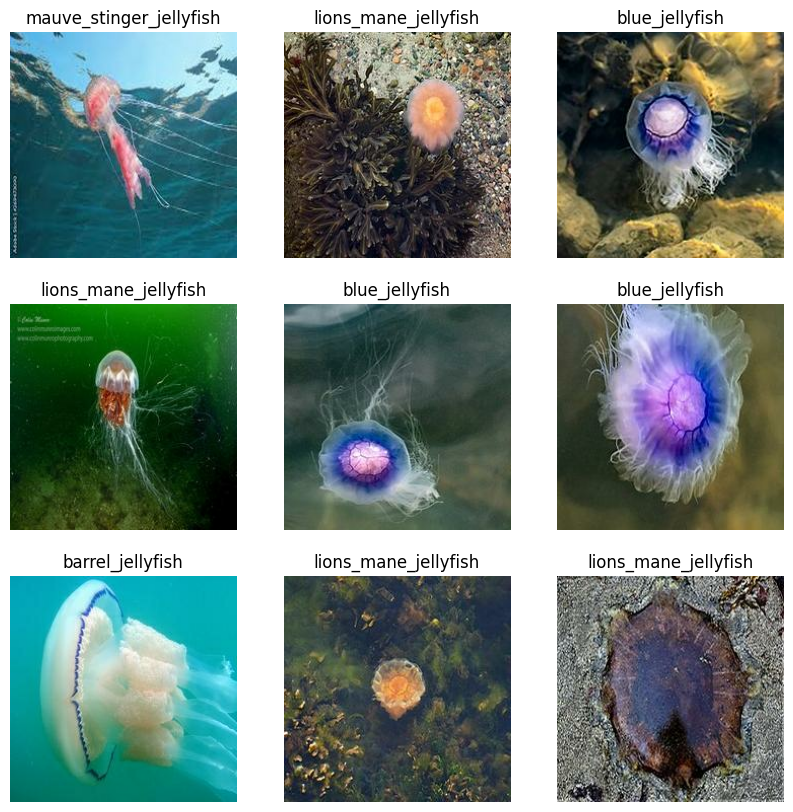

In [ ]:
# 원본 이미지 확인
# 9개의 랜덤 이미지 추출
random_indices = np.random.choice(X_train.shape[0], size=9, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  ax.imshow(X_train[random_indices[i]])
  ax.set_title(list(class_dict.keys())[y_train[random_indices[i]]])
  ax.axis('off')
plt.show()


### 훈련 데이터 증강

In [ ]:
# Construct the tf.data pipeline
train_dataset_no_aug = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset_no_aug = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

# Construct the tf.data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(lambda img, label: augment(img, label,
            crop_ratio=0.9,
            saturation = (0.4, 1.0),
            brightness_max_delta=0.2,
            random_contrast=(0.95,1.00),
            random_hue = 0.2,
            random_flip_left_right = True,
            random_flip_up_down = True,
            random_rotation = 360, #TODO: There is only 90 degree flip
            gaussian_noise_mean=0.05,
            gaussian_noise_stddev=0.1
            ),
    num_parallel_calls=tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(lambda img, label: augment(img, label,
            crop_ratio=0.9,
            # saturation = (0.4, 1.0),
            # brightness_max_delta=0.2,
            random_contrast=(0.9,1.0),
            # random_hue = 0.2,
            random_flip_left_right = True,
            random_flip_up_down = True,
            random_rotation = 360,
            gaussian_noise_mean=0.02,
            gaussian_noise_stddev=0.02
            ), num_parallel_calls=tf.data.AUTOTUNE)

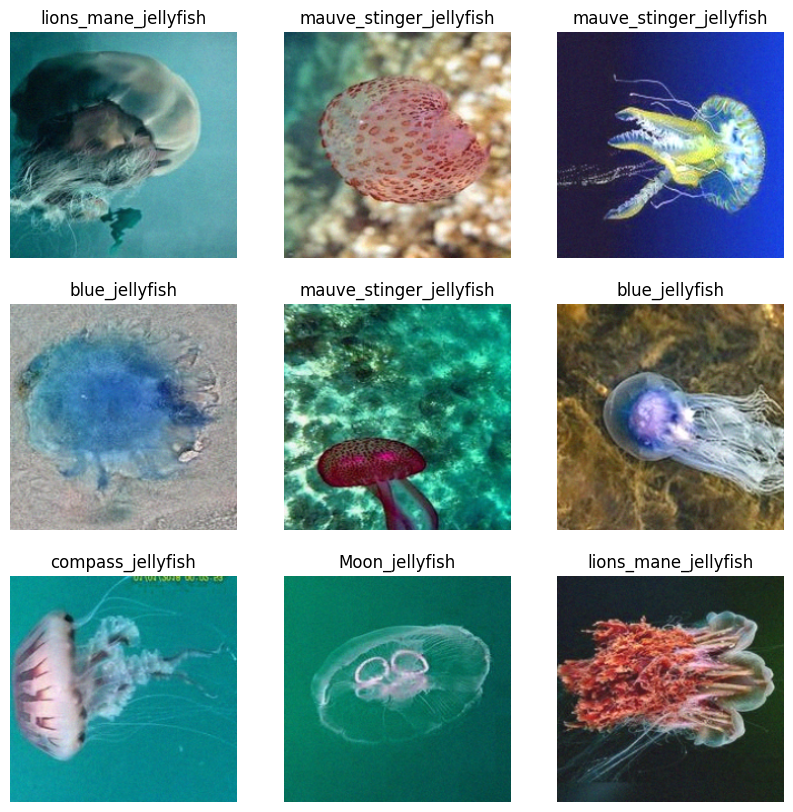

In [ ]:
aug_imgs = [img for img in valid_dataset.shuffle(1000).take(9)]
# 훈련용 증강 이미지 확인 (datagen x)
# 9개의 랜덤 이미지 추출
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  ax.imshow(aug_imgs[i][0].numpy().clip(0,1))
  ax.set_title(list(class_dict.keys())[aug_imgs[i][1]])
  ax.axis('off')
plt.show()

### 모델 정의 및 훈련

In [ ]:
# [EfficientNetB0/VGG16] 분류기 초기화
classifier = JellyfishClassifier(
    num_classes=6,  # 해파리 클래스 수
    #model_type='efficientnet',
    model_type='VGG16',
    pretrained=True,  # ImageNet 가중치 사용
    metrics=['accuracy', 'f1_score'],  # 평가 지표에서 entropy 제거 -> evaluate 에서 계산
    learning_rate=1e-4  # 학습률 조정
)
# 2. 분류기 인스턴스에서 모델 서머리 출력:
classifier.model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_26          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 14,848,582 (56.64 MB)

 Trainable params: 133,382 (521.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

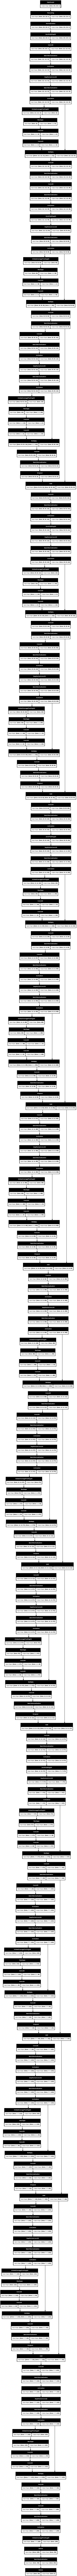

In [ ]:
tf.keras.utils.plot_model(classifier.model, show_shapes=True)

In [ ]:
# 모델 훈련
# JellyfishClassifier 클래스 내부의 fit 메서드에서 TTA 자동 적용
classifier.fit(
    #train_dataset, valid_dataset_no_aug,  # train_dataset: 이터레이터를 통해 증강된 이미지들
    #train_dataset_no_aug, valid_dataset_no_aug,
    train_dataset, valid_dataset,
    epochs=500,
    early_stopping=-1,
    batch_size=32
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.1892 - loss: 2.3069 - val_accuracy: 0.2797 - val_loss: 3.0990
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3010 - loss: 2.0039 - val_accuracy: 0.3305 - val_loss: 2.1384
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3762 - loss: 1.6620 - val_accuracy: 0.3814 - val_loss: 1.6997
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4851 - loss: 1.4443 - val_accuracy: 0.5169 - val_loss: 1.3930
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4904 - loss: 1.4100 - val_accuracy: 0.5254 - val_loss: 1.4126
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5679 - loss: 1.2836 - val_accuracy: 0.5424 - val_loss: 1.1867
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6125 - loss: 1.0895 - val_accuracy: 0.5763 - val_loss: 1.1097
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6654 - loss: 0.9982 - val_accuracy: 0

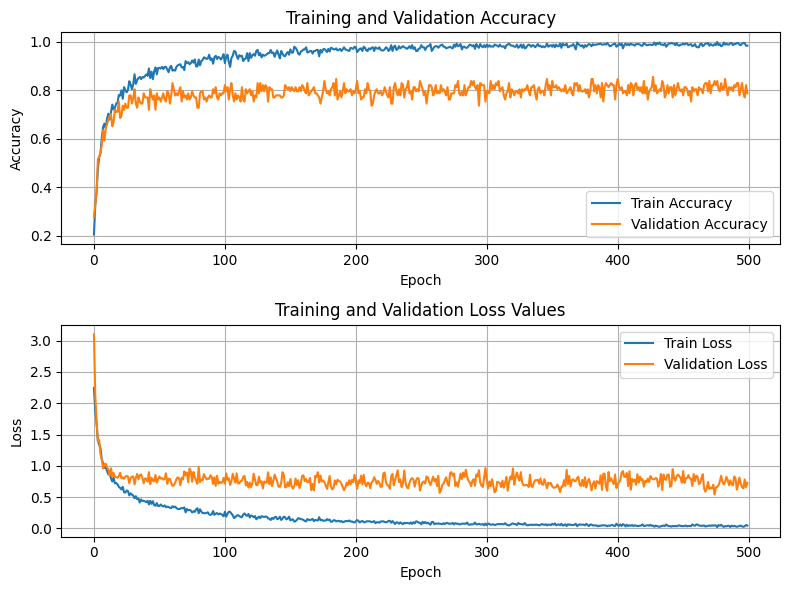

In [ ]:
# 훈련 검증 시각화
# classifier 객체가 검증 지표를 담은 history 를 가지고 있음
history = classifier.history

fig, ax = plt.subplots(figsize = (8, 6), nrows = 2)
ax[0].set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax[0].grid()
ax[0].plot(history['accuracy'], label='Train Accuracy')
ax[0].plot(history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()

ax[1].set(title='Training and Validation Loss Values', xlabel='Epoch', ylabel='Loss')
ax[1].grid()
ax[1].plot(history['loss'], label='Train Loss')
ax[1].plot(history['val_loss'], label='Validation Loss')
ax[1].legend()

fig.tight_layout()

In [ ]:
classifier.model.evaluate(X_train, y_train), classifier.model.evaluate(X_valid, y_valid)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1764 - loss: 3.2175
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1584 - loss: 3.3564


([3.256296157836914, 0.16849015653133392],
 [3.306079626083374, 0.16949152946472168])

In [ ]:
#classifier.predict(X_train)
#print(np.argmax(classifier.model.predict(X_valid), axis = 1))
#print(classifier.model.predict(X_valid))

### 추론 및 검증

In [ ]:
# Test-Time-Augmentation (TTA)
'''
테스트 시간에 어떤 증강을 넣을 지 설정할 수 있다.
tta = None: 테스트 데이터를 증강하지 않는다.
hard_voting: hard_voting=True
soft_voting: hard_voting=False
n_augmentation: 테스트 샘플 당 증강 이미지 개수
'''
tta_aug = lambda img: augment(img, label = None,
            crop_ratio=0.9,
            saturation = (0.4, 1.0),
            brightness_max_delta=0.5,
            random_contrast=(0.9,1.1),
            random_hue = 0.1)

pred = classifier.predict(X_valid, tta = None)
pred_tta_soft_voting = classifier.predict(X_valid, tta = tta_aug, hard_voting = False, n_augmentations = 10)
pred_tta_hard_voting = classifier.predict(X_valid, tta = tta_aug, hard_voting = True, n_augmentations = 10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step


Predicting with TTA:   0%|          | 0/118 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Predicting with TTA:   1%|          | 1/118 [00:00<01:36,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   2%|▏         | 2/118 [00:01<01:08,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   3%|▎         | 3/118 [00:01<00:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   3%|▎         | 4/118 [00:02<00:56,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   4%|▍         | 5/118 [00:02<00:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:   5%|▌         | 6/118 [00:03<00:51,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:   6%|▌         | 7/118 [00:03<00:50,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   7%|▋         | 8/118 [00:03<00:49,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:   8%|▊         | 9/118 [00:04<00:49,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   8%|▊         | 10/118 [00:04<00:48,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   9%|▉         | 11/118 [00:05<00:47,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Predicting with TTA:  10%|█         | 12/118 [00:05<00:47,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  11%|█         | 13/118 [00:06<00:47,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  12%|█▏        | 14/118 [00:06<00:46,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  13%|█▎        | 15/118 [00:07<00:46,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  14%|█▎        | 16/118 [00:07<00:45,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  14%|█▍        | 17/118 [00:07<00:44,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  15%|█▌        | 18/118 [00:08<00:44,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  16%|█▌        | 19/118 [00:08<00:43,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  17%|█▋        | 20/118 [00:09<00:43,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  18%|█▊        | 21/118 [00:09<00:42,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  19%|█▊        | 22/118 [00:10<00:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  19%|█▉        | 23/118 [00:10<00:42,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  20%|██        | 24/118 [00:10<00:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  21%|██        | 25/118 [00:11<00:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  22%|██▏       | 26/118 [00:11<00:40,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  23%|██▎       | 27/118 [00:12<00:40,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  24%|██▎       | 28/118 [00:12<00:39,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  25%|██▍       | 29/118 [00:13<00:38,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  25%|██▌       | 30/118 [00:13<00:38,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  26%|██▋       | 31/118 [00:14<00:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  27%|██▋       | 32/118 [00:14<00:37,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  28%|██▊       | 33/118 [00:14<00:37,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  29%|██▉       | 34/118 [00:15<00:36,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  30%|██▉       | 35/118 [00:15<00:36,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  31%|███       | 36/118 [00:16<00:35,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  31%|███▏      | 37/118 [00:16<00:35,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  32%|███▏      | 38/118 [00:17<00:35,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  33%|███▎      | 39/118 [00:17<00:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  34%|███▍      | 40/118 [00:18<00:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  35%|███▍      | 41/118 [00:18<00:33,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  36%|███▌      | 42/118 [00:18<00:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  36%|███▋      | 43/118 [00:19<00:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  37%|███▋      | 44/118 [00:19<00:32,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  38%|███▊      | 45/118 [00:20<00:32,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  39%|███▉      | 46/118 [00:20<00:31,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  40%|███▉      | 47/118 [00:21<00:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  41%|████      | 48/118 [00:21<00:30,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  42%|████▏     | 49/118 [00:21<00:30,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  42%|████▏     | 50/118 [00:22<00:29,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  43%|████▎     | 51/118 [00:22<00:29,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting with TTA:  44%|████▍     | 52/118 [00:23<00:29,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  45%|████▍     | 53/118 [00:23<00:28,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  46%|████▌     | 54/118 [00:24<00:28,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  47%|████▋     | 55/118 [00:24<00:27,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  47%|████▋     | 56/118 [00:25<00:27,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  48%|████▊     | 57/118 [00:25<00:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  49%|████▉     | 58/118 [00:25<00:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  50%|█████     | 59/118 [00:26<00:25,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  51%|█████     | 60/118 [00:26<00:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  52%|█████▏    | 61/118 [00:27<00:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  53%|█████▎    | 62/118 [00:27<00:24,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  53%|█████▎    | 63/118 [00:28<00:23,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  54%|█████▍    | 64/118 [00:28<00:23,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  55%|█████▌    | 65/118 [00:29<00:23,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  56%|█████▌    | 66/118 [00:29<00:22,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  57%|█████▋    | 67/118 [00:29<00:22,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  58%|█████▊    | 68/118 [00:30<00:22,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  58%|█████▊    | 69/118 [00:30<00:21,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  59%|█████▉    | 70/118 [00:31<00:21,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  60%|██████    | 71/118 [00:31<00:20,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  61%|██████    | 72/118 [00:32<00:20,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  62%|██████▏   | 73/118 [00:32<00:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  63%|██████▎   | 74/118 [00:33<00:19,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  64%|██████▎   | 75/118 [00:33<00:18,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  64%|██████▍   | 76/118 [00:33<00:18,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  65%|██████▌   | 77/118 [00:34<00:17,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  66%|██████▌   | 78/118 [00:34<00:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  67%|██████▋   | 79/118 [00:35<00:17,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  68%|██████▊   | 80/118 [00:35<00:16,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  69%|██████▊   | 81/118 [00:36<00:16,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  69%|██████▉   | 82/118 [00:36<00:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  70%|███████   | 83/118 [00:36<00:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  71%|███████   | 84/118 [00:37<00:15,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  72%|███████▏  | 85/118 [00:37<00:14,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  73%|███████▎  | 86/118 [00:38<00:13,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  74%|███████▎  | 87/118 [00:38<00:13,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting with TTA:  75%|███████▍  | 88/118 [00:39<00:13,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  75%|███████▌  | 89/118 [00:39<00:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  76%|███████▋  | 90/118 [00:40<00:12,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  77%|███████▋  | 91/118 [00:40<00:11,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  78%|███████▊  | 92/118 [00:40<00:11,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  79%|███████▉  | 93/118 [00:41<00:11,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  80%|███████▉  | 94/118 [00:41<00:10,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  81%|████████  | 95/118 [00:42<00:10,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  81%|████████▏ | 96/118 [00:42<00:09,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  82%|████████▏ | 97/118 [00:43<00:09,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  83%|████████▎ | 98/118 [00:43<00:09,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  84%|████████▍ | 99/118 [00:44<00:08,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  85%|████████▍ | 100/118 [00:44<00:07,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  86%|████████▌ | 101/118 [00:44<00:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  86%|████████▋ | 102/118 [00:45<00:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  87%|████████▋ | 103/118 [00:45<00:06,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  88%|████████▊ | 104/118 [00:46<00:06,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  89%|████████▉ | 105/118 [00:46<00:05,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  90%|████████▉ | 106/118 [00:47<00:05,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  91%|█████████ | 107/118 [00:47<00:04,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  92%|█████████▏| 108/118 [00:47<00:04,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  92%|█████████▏| 109/118 [00:48<00:03,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  93%|█████████▎| 110/118 [00:48<00:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  94%|█████████▍| 111/118 [00:49<00:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  95%|█████████▍| 112/118 [00:49<00:02,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  96%|█████████▌| 113/118 [00:50<00:02,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  97%|█████████▋| 114/118 [00:50<00:01,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  97%|█████████▋| 115/118 [00:51<00:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  98%|█████████▊| 116/118 [00:51<00:00,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  99%|█████████▉| 117/118 [00:51<00:00,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   0%|          | 0/118 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   1%|          | 1/118 [00:00<00:50,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   2%|▏         | 2/118 [00:00<00:49,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   3%|▎         | 3/118 [00:01<00:50,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:   3%|▎         | 4/118 [00:01<00:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:   4%|▍         | 5/118 [00:02<00:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:   5%|▌         | 6/118 [00:02<00:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:   6%|▌         | 7/118 [00:03<00:48,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   7%|▋         | 8/118 [00:03<00:49,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:   8%|▊         | 9/118 [00:03<00:48,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:   8%|▊         | 10/118 [00:04<00:47,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:   9%|▉         | 11/118 [00:04<00:46,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  10%|█         | 12/118 [00:05<00:46,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  11%|█         | 13/118 [00:05<00:46,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  12%|█▏        | 14/118 [00:06<00:45,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  13%|█▎        | 15/118 [00:06<00:45,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  14%|█▎        | 16/118 [00:07<00:44,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  14%|█▍        | 17/118 [00:07<00:44,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  15%|█▌        | 18/118 [00:07<00:43,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  16%|█▌        | 19/118 [00:08<00:43,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  17%|█▋        | 20/118 [00:08<00:42,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  18%|█▊        | 21/118 [00:09<00:42,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  19%|█▊        | 22/118 [00:09<00:42,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  19%|█▉        | 23/118 [00:10<00:41,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  20%|██        | 24/118 [00:10<00:41,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  21%|██        | 25/118 [00:10<00:40,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  22%|██▏       | 26/118 [00:11<00:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  23%|██▎       | 27/118 [00:11<00:40,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  24%|██▎       | 28/118 [00:12<00:39,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  25%|██▍       | 29/118 [00:12<00:39,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  25%|██▌       | 30/118 [00:13<00:38,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  26%|██▋       | 31/118 [00:13<00:38,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  27%|██▋       | 32/118 [00:14<00:38,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  28%|██▊       | 33/118 [00:14<00:37,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  29%|██▉       | 34/118 [00:14<00:37,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  30%|██▉       | 35/118 [00:15<00:36,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting with TTA:  31%|███       | 36/118 [00:15<00:36,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  31%|███▏      | 37/118 [00:16<00:35,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  32%|███▏      | 38/118 [00:16<00:35,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  33%|███▎      | 39/118 [00:17<00:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  34%|███▍      | 40/118 [00:17<00:34,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  35%|███▍      | 41/118 [00:17<00:33,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  36%|███▌      | 42/118 [00:18<00:33,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  36%|███▋      | 43/118 [00:18<00:32,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  37%|███▋      | 44/118 [00:19<00:32,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  38%|███▊      | 45/118 [00:19<00:31,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  39%|███▉      | 46/118 [00:20<00:31,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  40%|███▉      | 47/118 [00:20<00:31,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  41%|████      | 48/118 [00:21<00:30,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  42%|████▏     | 49/118 [00:21<00:29,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  42%|████▏     | 50/118 [00:21<00:29,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  43%|████▎     | 51/118 [00:22<00:29,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  44%|████▍     | 52/118 [00:22<00:28,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  45%|████▍     | 53/118 [00:23<00:28,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  46%|████▌     | 54/118 [00:23<00:27,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  47%|████▋     | 55/118 [00:24<00:27,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  47%|████▋     | 56/118 [00:24<00:27,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  48%|████▊     | 57/118 [00:24<00:26,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  49%|████▉     | 58/118 [00:25<00:26,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  50%|█████     | 59/118 [00:25<00:25,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  51%|█████     | 60/118 [00:26<00:25,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  52%|█████▏    | 61/118 [00:26<00:25,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  53%|█████▎    | 62/118 [00:27<00:24,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  53%|█████▎    | 63/118 [00:27<00:24,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  54%|█████▍    | 64/118 [00:28<00:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  55%|█████▌    | 65/118 [00:28<00:23,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  56%|█████▌    | 66/118 [00:28<00:22,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  57%|█████▋    | 67/118 [00:29<00:22,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  58%|█████▊    | 68/118 [00:29<00:21,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  58%|█████▊    | 69/118 [00:30<00:21,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  59%|█████▉    | 70/118 [00:30<00:21,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  60%|██████    | 71/118 [00:31<00:20,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  61%|██████    | 72/118 [00:31<00:20,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  62%|██████▏   | 73/118 [00:32<00:19,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  63%|██████▎   | 74/118 [00:32<00:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  64%|██████▎   | 75/118 [00:32<00:18,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  64%|██████▍   | 76/118 [00:33<00:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  65%|██████▌   | 77/118 [00:33<00:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  66%|██████▌   | 78/118 [00:34<00:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  67%|██████▋   | 79/118 [00:34<00:17,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  68%|██████▊   | 80/118 [00:35<00:16,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  69%|██████▊   | 81/118 [00:35<00:16,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  69%|██████▉   | 82/118 [00:35<00:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  70%|███████   | 83/118 [00:36<00:15,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  71%|███████   | 84/118 [00:36<00:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  72%|███████▏  | 85/118 [00:37<00:14,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  73%|███████▎  | 86/118 [00:37<00:14,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  74%|███████▎  | 87/118 [00:38<00:13,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  75%|███████▍  | 88/118 [00:38<00:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  75%|███████▌  | 89/118 [00:39<00:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  76%|███████▋  | 90/118 [00:39<00:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  77%|███████▋  | 91/118 [00:39<00:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  78%|███████▊  | 92/118 [00:40<00:11,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  79%|███████▉  | 93/118 [00:40<00:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  80%|███████▉  | 94/118 [00:41<00:10,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  81%|████████  | 95/118 [00:41<00:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  81%|████████▏ | 96/118 [00:42<00:09,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  82%|████████▏ | 97/118 [00:42<00:09,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  83%|████████▎ | 98/118 [00:43<00:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  84%|████████▍ | 99/118 [00:43<00:08,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  85%|████████▍ | 100/118 [00:43<00:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  86%|████████▌ | 101/118 [00:44<00:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  86%|████████▋ | 102/118 [00:44<00:07,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  87%|████████▋ | 103/118 [00:45<00:06,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  88%|████████▊ | 104/118 [00:45<00:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  89%|████████▉ | 105/118 [00:46<00:05,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting with TTA:  90%|████████▉ | 106/118 [00:46<00:05,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  91%|█████████ | 107/118 [00:47<00:04,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  92%|█████████▏| 108/118 [00:47<00:04,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting with TTA:  92%|█████████▏| 109/118 [00:47<00:03,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  93%|█████████▎| 110/118 [00:48<00:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting with TTA:  94%|█████████▍| 111/118 [00:48<00:03,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  95%|█████████▍| 112/118 [00:49<00:02,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  96%|█████████▌| 113/118 [00:49<00:02,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  97%|█████████▋| 114/118 [00:50<00:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting with TTA:  97%|█████████▋| 115/118 [00:50<00:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA:  98%|█████████▊| 116/118 [00:51<00:00,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting with TTA:  99%|█████████▉| 117/118 [00:51<00:00,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting with TTA: 100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


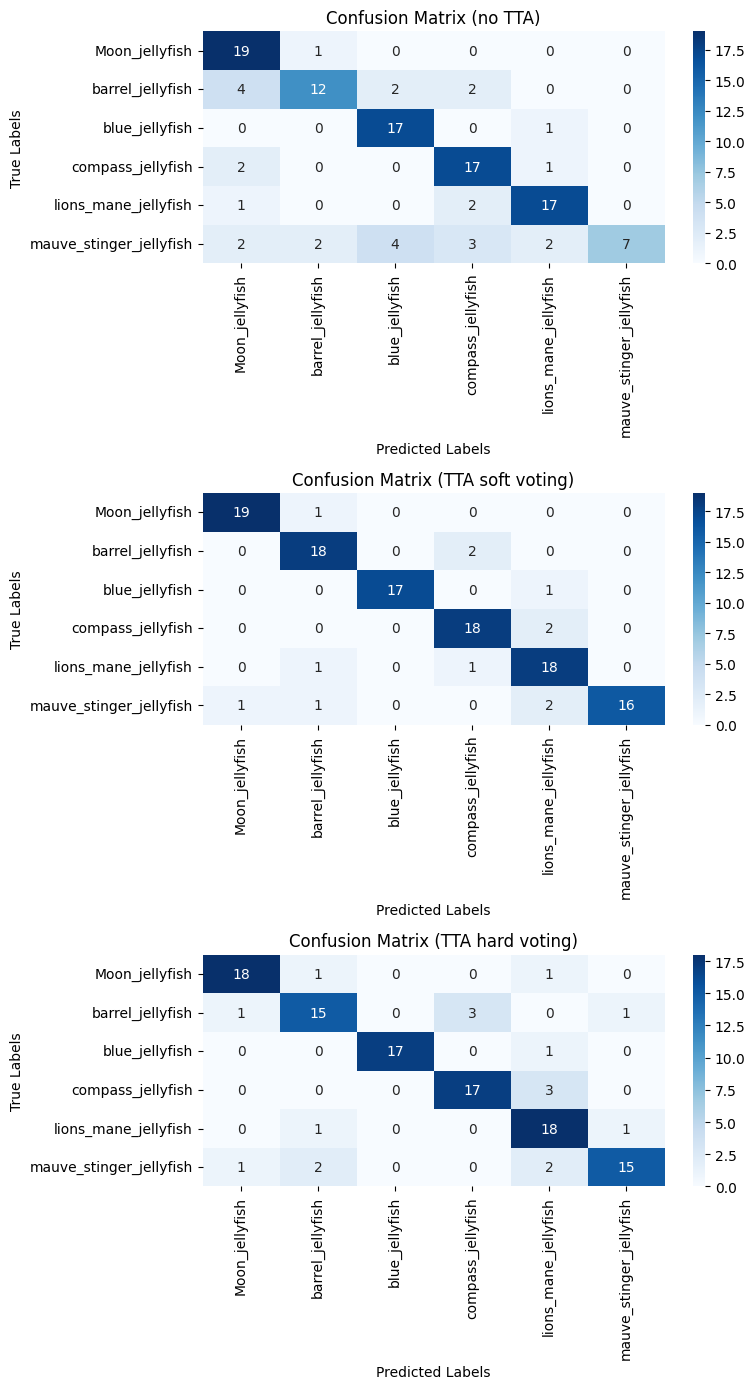

In [ ]:
classes = {v: k for k, v in class_dict.items()}

fig, ax = plt.subplots(figsize=(8, 14), nrows = 3)
sns.heatmap(confusion_matrix(y_valid, pred), ax = ax[0], annot=True, fmt='d', cmap='Blues', xticklabels=[classes[c] for c in sorted(classes.keys())], yticklabels=[classes[c] for c in sorted(classes.keys())])
sns.heatmap(confusion_matrix(y_valid, pred_tta_soft_voting), ax = ax[1], annot=True, fmt='d', cmap='Blues', xticklabels=[classes[c] for c in sorted(classes.keys())], yticklabels=[classes[c] for c in sorted(classes.keys())])
sns.heatmap(confusion_matrix(y_valid, pred_tta_hard_voting), ax = ax[2], annot=True, fmt='d', cmap='Blues', xticklabels=[classes[c] for c in sorted(classes.keys())], yticklabels=[classes[c] for c in sorted(classes.keys())])

ax[0].set_title('Confusion Matrix (no TTA)')
ax[1].set_title('Confusion Matrix (TTA soft voting)')
ax[2].set_title('Confusion Matrix (TTA hard voting)')

for axis in ax:
    axis.set_xlabel('Predicted Labels')
    axis.set_ylabel('True Labels')
fig.tight_layout()


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):  # pred_index : 관심 클래스의 인덱스
    # Grad-CAM 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient 계산
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient의 평균 계산, 모델이 어느 클래스 방향으로 더 당겼는지?
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap 생성
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # 이미지 로드 및 크기 조정
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Heatmap 크기 조정 및 색상 적용
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Heatmap과 원본 이미지 합치기
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)  # 픽셀 값 범위 조정

    # 결과 출력
    plt.figure(figsize=(8, 8))  # 이미지 크기 조정 (필요에 따라 변경)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Visualization")  # 제목 설정 (필요에 따라 변경)
    plt.axis('off')  # 축 제거
    plt.show()

In [ ]:
last_conv_layer_name = "block5_conv3"  # VGG16의 경우
gradcam_imgs = []
gradcam_heatmaps = []
for gaussian_noise_mean in np.hstack([np.linspace(0, 1, 10), np.linspace(0, 1, 10)[::-1]]):
    gradcam_dataset = tf.data.Dataset.from_tensor_slices((X_train[:1], y_train[:1])).map(lambda img, label: augment(img, label,
        crop_ratio=0.0,
        saturation = (0.0, 0.0),
        brightness_max_delta=0.0,
        random_contrast=(0.0,0.0),
        random_hue = 0.0,
        random_flip_left_right = False,
        random_flip_up_down = False,
        random_rotation = 0,
        gaussian_noise_mean=gaussian_noise_mean,
        gaussian_noise_stddev=0.1
        ),
        num_parallel_calls=tf.data.AUTOTUNE)

    gradcam_imgs.append(gradcam_dataset.shuffle(1).take(1))
    gradcam_heatmaps.append(make_gradcam_heatmap(gradcam_imgs[-1], classifier.model, last_conv_layer_name))
gradcam_imgs = np.array(gradcam_imgs)
gradcam_heatmaps = np.array(gradcam_heatmaps)

In [ ]:
last_conv_layer_name = "block5_conv3"  # VGG16의 경우

# Grad-CAM 히트맵 생성 및 시각화
heatmap = make_gradcam_heatmap(gradcam_imgs, classifier.model, last_conv_layer_name)
#display_gradcam(img_path, heatmap)

### Grad-CAM 시각화
- 빨간색: 모델이 가장 중요하다고 판단한 이미지 영역
- 파란색: 덜 중요하다고 본 부분

해피리의 촉수나 형태에 초점이 맞춰졌다면 잘 학습된 것

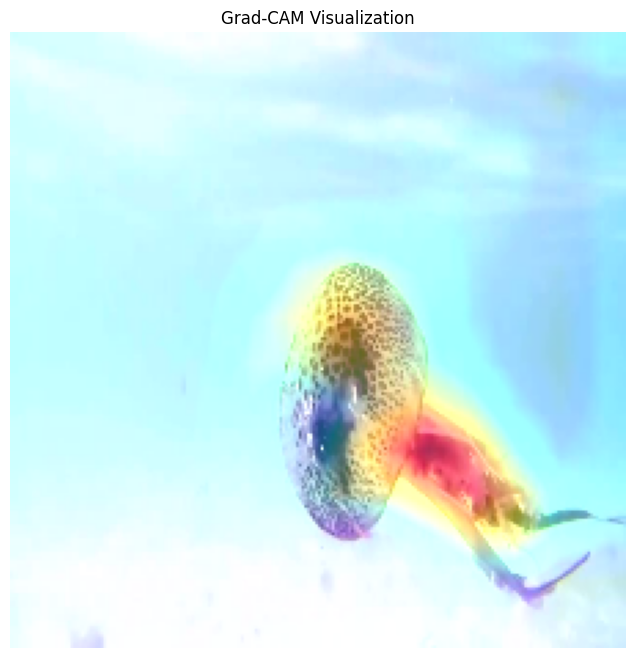

In [ ]:
# 이미지 경로
img_path = "/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/ext_dataset/pelagia26_IMG_00009.jpg"

# 이미지 전처리
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # 정규화

# 마지막 컨볼루션 레이어 이름
last_conv_layer_name = "block5_conv3"  # VGG16의 경우

# Grad-CAM 히트맵 생성 및 시각화
heatmap = make_gradcam_heatmap(img_array, classifier.model, last_conv_layer_name)
display_gradcam(img_path, heatmap)

### ( 더이상 사용하지는 않지만 ) 실험의 흔적

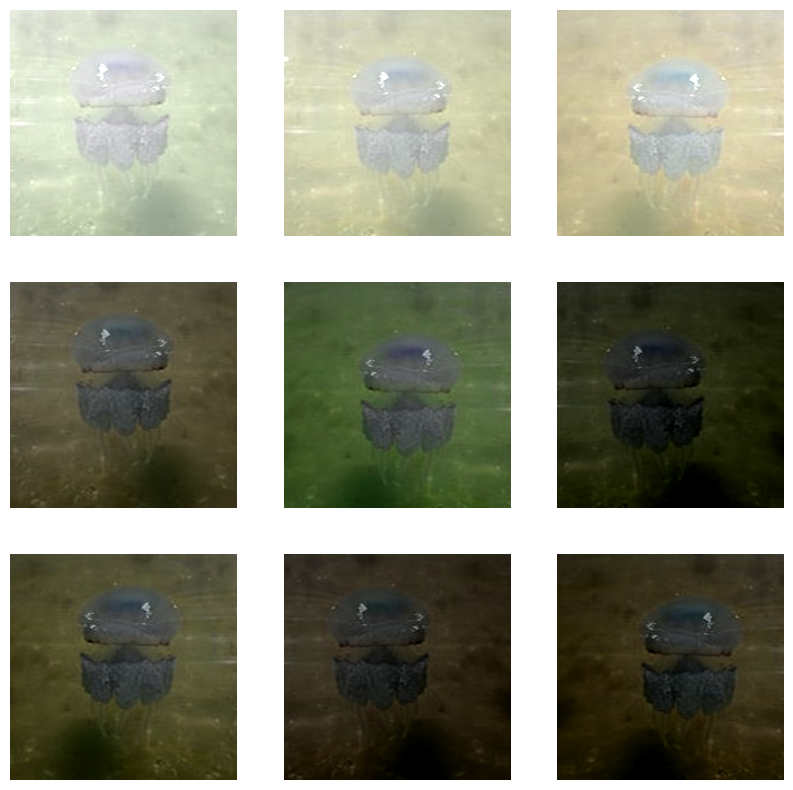

In [ ]:
# [테스트용] 데이터제너레이터를 사용하지 않은 TTA 증강 설정
# 임시 시각화를 위해 훈련 이미지 사용
tta_aug = lambda img: augment(img, label = None,
            crop_ratio=0.9,
            saturation = (0.4, 1.0),
            brightness_max_delta=0.5,
            random_contrast=(0.9,1.1),
            random_hue = 0.1)

tta_data = tf.data.Dataset.from_tensor_slices(([X_train[0]])).map(tta_aug,
    num_parallel_calls=tf.data.AUTOTUNE)

tta_imgs = [img[0].numpy() for img in tta_data.repeat().take(10)]

# 9개의 랜덤 이미지 추출하여 테스트 증강 시각화
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  ax.imshow(tta_imgs[i].clip(0, 1))
  ax.axis('off')
plt.show()

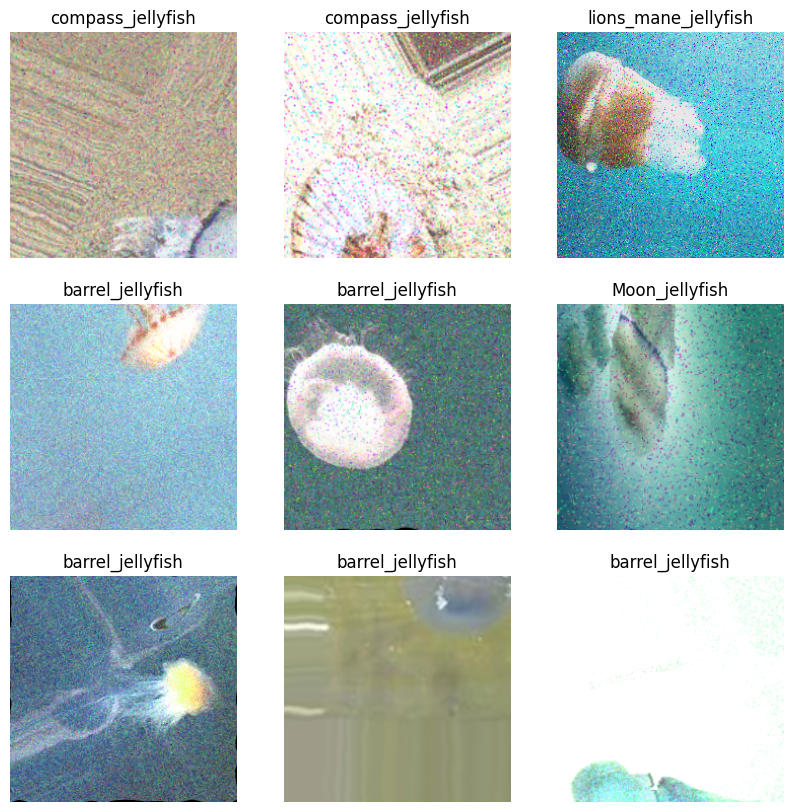

In [ ]:
# # 증강 이미지 확인 (datagen x)
# # 9개의 랜덤 이미지 추출
# random_indices = np.random.choice(aug_imgs.shape[0], size=9, replace=False)
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# for i, ax in enumerate(axes.flat):
#   ax.imshow(aug_imgs[random_indices[i]])
#   ax.set_title(list(class_dict.keys())[y_train[random_indices[i]]])
#   ax.axis('off')
# plt.show()